# Visualization and Exploration of OCO-2 SIF Lite data
---

In [1]:
import glob
import numpy as np
import xarray
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy
from palettable.scientific.diverging import Broc_10

NOTES:
- can files be opened from opendap link (see txt file in HPC dir)
- look at `xarray.DataArray.coarsen` and `xarray.core.rolling.DatasetCoarsen`

## What's in a single file?

In [2]:
# Notice that netcdf groups are ignored
filename = "../data/OCO2_SIF_Lite/2014/oco2_LtSIF_140906_B10206r_200730212646s.nc4"

ds = xarray.open_dataset(filename)    
ds

<xarray.Dataset>
Dimensions:                (sounding_dim: 176422, vertex_dim: 4)
Dimensions without coordinates: sounding_dim, vertex_dim
Data variables:
    Delta_Time             (sounding_dim) datetime64[ns] ...
    SZA                    (sounding_dim) float32 ...
    VZA                    (sounding_dim) float32 ...
    SAz                    (sounding_dim) float32 ...
    VAz                    (sounding_dim) float32 ...
    Longitude              (sounding_dim) float32 ...
    Latitude               (sounding_dim) float32 ...
    Longitude_Corners      (sounding_dim, vertex_dim) float32 ...
    Latitude_Corners       (sounding_dim, vertex_dim) float32 ...
    SIF_740nm              (sounding_dim) float32 ...
    SIF_Uncertainty_740nm  (sounding_dim) float32 ...
    Daily_SIF_740nm        (sounding_dim) float32 ...
    Daily_SIF_757nm        (sounding_dim) float32 ...
    Daily_SIF_771nm        (sounding_dim) float32 ...
    Quality_Flag           (sounding_dim) float32 ...
Attributes:
    References:                        ['Sun, Y. et al., Remote Sensing of En...
    conventions:                       CF-1.6
    product_version:                   B10206r
    summary:                           Fraunhofer-line based SIF retrievals
    keywords:                          ISS, OCO-2, Solar Induced Fluorescence...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    cdm_data:                          point
    comment:                           These data were produced at JPL/Caltech
    date_created:                      2020-07-30T21:26:46Z
    author_name:                       Jet Propulsion Laboratory/Caltech, Chr...
    author_email:                      Christian.Frankenberg@jpl.nasa.gov
    secondary_author_name:             Jet Propulsion Laboratory/Caltech, tho...
    secondary_author_email:            thomas.kurosu@jpl.nasa.gov
    project:                           OCO-2 NASA/JPL
    geospatial_lat_min:                -90.0
    geospatial_lat_max:                90.0
    geospatial_lat_units:              degrees_north
    geospatial_lon_min:                -180.0
    geospatial_lon_max:                180.0
    geospatial_lon_units:              degrees_east
    platform:                          OCO-2 Satellite Spacecraft
    sensor:                            OCO-2 NASA/JPL
    spatial_resolution:                2.1km x 1.3km at nadir (along-track x ...
    date_time_coverage:                ['2014-09-06T01:47:00.894907Z', '2014-...
    day_of_year_coverage:              ['2014-249T01:47:00.894907Z', '2014-24...
    InputCollectionLabel:              Ops_B10003_r02
    InputBuildId:                      B10.0.03
    InputPointers:                     oco2_L2MetND_00958a_140906_B10003r_191...
    CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    identifier_product_doi_authority:  http://dx.doi.org/
    identifier_product_doi:            10.5067/XO2LBBNPO010

## Plot a day of SIF retrievals

In [3]:
def preprocess(ds):
    # Consider adding lat/lon as dimensions as well
        dsnew = xarray.Dataset(
            {
                "sif": (["time"], ds.Daily_SIF_757nm),
            },
            coords={
                "lon": (["time"], ds.Longitude),
                "lat": (["time"], ds.Latitude),
                "time": ds.Delta_Time.values
            }
        )
#         .expand_dims({
#             "lon": ds.Longitude, 
#             "lat": ds.Latitude
#         })

        return dsnew

In [4]:
filename = "../data/OCO2_SIF_Lite/2014/oco2_LtSIF_140906_B10206r_200730212646s.nc4"

with xarray.open_dataset(filename) as ds:
    ds = preprocess(ds)
    
ds

<xarray.Dataset>
Dimensions:  (time: 176422)
Coordinates:
    lon      (time) float32 -179.75006 -179.7583 ... -165.4884 -165.50293
    lat      (time) float32 -19.618774 -19.625916 ... 62.217712 62.23694
  * time     (time) datetime64[ns] 2014-09-06T01:47:00.898437504 ... 2014-09-...
Data variables:
    sif      (time) float32 -0.090768814 0.10644817 ... 0.18840313 -0.04426956

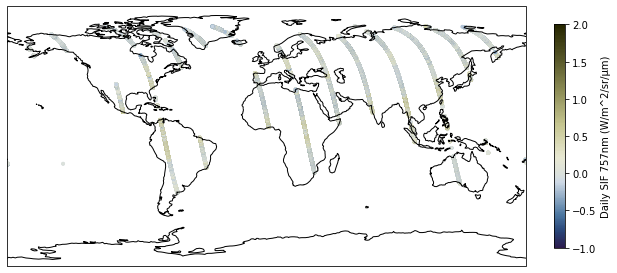

In [5]:
# Plot Daily SIF data
fig = plt.figure(figsize=(10,12))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.style.use("default")
cm = Broc_10.mpl_colormap

# center the colormap at 0
offset = colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=2)

ax.set_global()
ax.coastlines()
s = ax.scatter(ds.lon, ds.lat, c=ds.sif, 
               s=8, cmap=cm, norm=offset, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mappable=s, ax=ax, fraction=0.02, pad=0.05)
cbar.set_label("Daily SIF 757nm (W/m^2/sr/µm)")
# plt.savefig("../plots/sif_single_day.png");

## Read in all netcdf files

In [6]:
# Open multiple datasets across yearly subdirectories
list_of_paths = glob.glob("../data/OCO2_SIF_Lite/*/*.nc4")

with xarray.open_mfdataset(list_of_paths, preprocess=preprocess, parallel=True) as ds:
    DS = ds

In [8]:
# Attempt to open files directly from opendap
# from pydap.client import open_url
# from pydap.cas.urs import setup_session

# url = "https://oco2.gesdisc.eosdis.nasa.gov/opendap//OCO2_L2_Lite_SIF.10r/2020/oco2_LtSIF_200731_B10206r_200810180155s.nc4"
# username = "joshhjacobson"
# password = "4c0c9t*3HA5o"

# session = setup_session(username, password, check_url=url)
# pydap_ds = open_url(url, session=session)
# store = xarray.backends.PydapDataStore(pydap_ds)
# ds = xarray.open_dataset(store)

## 16 day window

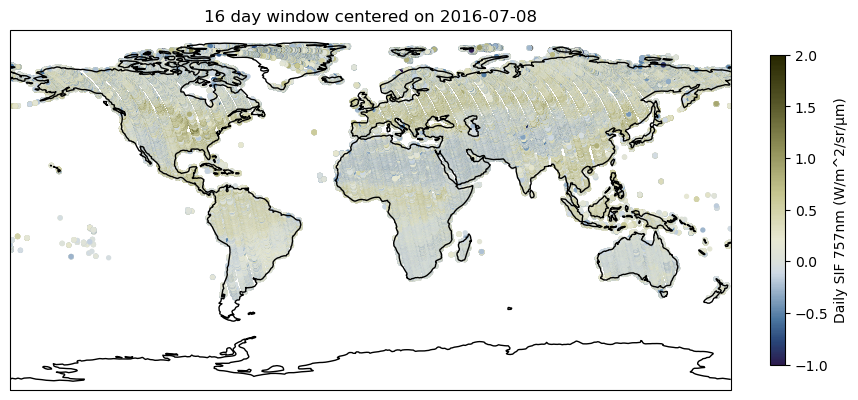

In [9]:
sif_window = DS.sel(time=slice("2016-07-01", "2016-07-16"))

fig = plt.figure(figsize=(10,12))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.style.use("default")
cm = Broc_10.mpl_colormap

# center the colormap at 0
offset = colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=2)

ax.set_global()
ax.coastlines()
s = ax.scatter(sif_window.lon, sif_window.lat, c=sif_window.sif, 
               s=8, cmap=cm, norm=offset, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mappable=s, ax=ax, fraction=0.02, pad=0.05)
cbar.set_label("Daily SIF 757nm (W/m^2/sr/µm)")
plt.title("16 day window centered on 2016-07-08")
# plt.savefig("../plots/sif_16day_window.png");

## Produce monthly climatology

In [10]:
sif_clima_month = DS.sif.resample(time="1MS").mean(dim="time").to_dataframe()
sif_clima_month.head()

,sif
time,
2014-09-01,0.083272
2014-10-01,0.066533
2014-11-01,0.047827
2014-12-01,0.045286
2015-01-01,0.048568


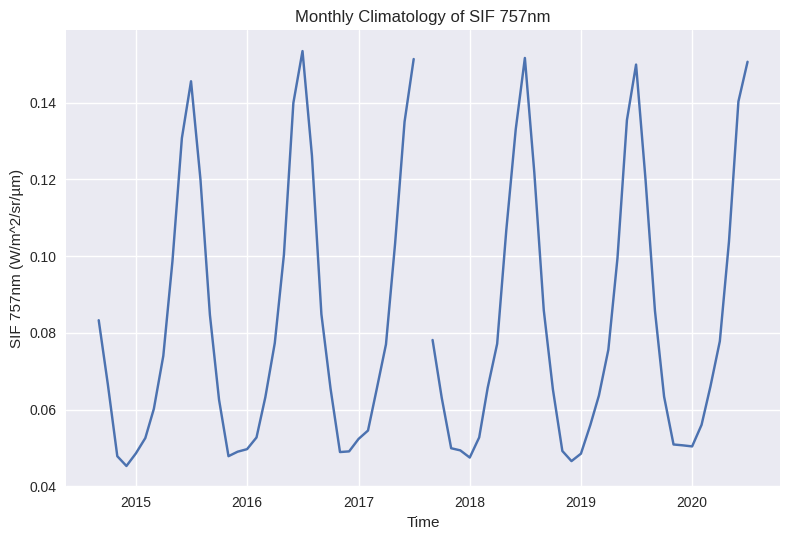

In [13]:
plt.style.use("seaborn")
# plt.figure(figsize=(8,6))
sns.lineplot(data=sif_clima_month, x="time", y="sif")
plt.xlabel("Time")
plt.ylabel("SIF 757nm (W/m^2/sr/µm)")
plt.title("Monthly Climatology of SIF 757nm")
plt.tight_layout()
# plt.savefig("../plots/sif_monthly_climatology.png");

## Look at mean/median of data spatially, maybe group by month or year

In [7]:
## Break data apart into monthly sections then compute statistic of 1-degree spatial bin

## start with one month
DS_1m = DS.sel(time=slice("2020-01-01", "2020-01-31"))

In [32]:
## NOTE: maybe try with a spatial subset or even just one day first?
## Is there a more efficient way to write this?

# Establish a regular grid
lon = np.arange(-179.5, 179.5)
lat = np.arange(-60.5, 60.5)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Compute mean / median SIF over the grid
sif_grid = np.zeros_like(lat_grid)
for i in range(lat.size):
    for j in range(lon.size):
        window = [lat[i], lat[i+1], lon[j], lon[j+1]]
        mask = (DS.lat >= window[0]) & (DS.lat <= window[1]) &\
               (DS.lon >= window[2]) & (DS.lon <= window[3]) 
                 
        sif_grid[j, i] = DS.sif.where(mask).mean()

KeyboardInterrupt: 

## Latitude-banded Hovmoller diagrams

In [ ]:
# Construct 1-degree latitude bands
bands = np.arange(-60, 61, 1)

# 
DS.groupby_bins("lat", bands).groups

## EOF Analysis?